# Working with text data

We are currently at step 1, data preparation and sampling.

To prepare input texts, we need to separate it into individual words and tokens to be able to encode them.

Embedding refers to the process of converting data in this case text into a vector format.

The purpose is to have a data format which neural networks can process

There are different embeddings, however we will focus on words embeddings as we want to generate one at a time.

Word embeddings can have varying dimensions, from one to thousands. A higher
dimensionality might capture more nuanced relationships but at the cost of computational efficiency.

In [10]:
# To practice this, we will use the-verdict.txt file
with open("the-verdict.txt", "r", encoding="utf-8") as f:
 raw_text = f.read()
print("Total number of character:", len(raw_text))
print(raw_text[:99])

# We wish to turn all this characters into tokens which we can embedd

# To obtain the different set of characters we use the re library
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)
print("Separating words: ",result)

# We wish to separate dots and commas to separate instances
result = re.split(r'([,.]|\s)', text)
print("Separating dots and commas: ",result)

# If we wish to remove blank space characters
result = [item for item in result if item.strip()]
print("Removing blank spaces: ",result)

# Removing white spaces can depend on what the focus is as it can be memory efficient or needed to avoid erros.

# Taking into account all punctuaction terms
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print("With punctuation: ", result)

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
Separating words:  ['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']
Separating dots and commas:  ['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']
Removing blank spaces:  ['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']
With punctuation:  ['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [11]:
# Applying this to our whole text
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print("Total amount of tokens (no whitespaces): ",len(preprocessed))

print("First 30 tokens: ",preprocessed[:30])

Total amount of tokens (no whitespaces):  4690
First 30 tokens:  ['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


We need to provide token ID, in other words, assign each token to a number

In [12]:
all_words = sorted(set(preprocessed)) # Set obtains unique tokens, sorted orders them in alphabetical order
print(len(all_words)) 

# Printing the first 51 elements
vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
 print(item)
 if i >= 50:
    break

1130
('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


We will create a class that both encodes words into tokens and thus TokenID and a decoder to reverse this operation

In [13]:
class SimpleTokenizerV1:
 def __init__(self, vocab):
    self.str_to_int = vocab # Maps strings to tokens
    self.int_to_str = {i:s for s,i in vocab.items()} # Reverse mapping

 def encode(self, text):
    preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text) # Tokenizes items
    preprocessed = [
    item.strip() for item in preprocessed if item.strip()
    ] # Ensures empty spaces are cleaned
    ids = [self.str_to_int[s] for s in preprocessed] # Converts each token into its integer ID
    return ids

 def decode(self, ids):
    text = " ".join([self.int_to_str[i] for i in ids]) # Integer to string

    text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) # Joins strings with a space
    return text

In [14]:
# Trying this class with a small subtext
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know,"
 Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print("Token ID: ",ids)
print("Texts decoded: ", tokenizer.decode(ids))

# As this works, trying with a different training set
text = "Hello, do you like tea?"
# print(tokenizer.encode(text))

# Error, due to Hello not appearing on the original text

Token ID:  [1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]
Texts decoded:  " It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


We need to make changes to adapt to unknown words, we will modify vocabulary and tokenizers

Special tokenizers will handle this

We can create a tokenizer which handles unknow words, and another for unrelated texts. The latter helps as if we insert independent texts, they are presented in a single manner, however they are actually unrelated.



In [15]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"]) # Adding the two newest tokens
vocab = {token:integer for integer,token in enumerate(all_tokens)}
print(len(vocab.items()))

1132


Therefore we update our current code with some slight changes

In [16]:
class SimpleTokenizerV2:
 def __init__(self, vocab):
    self.str_to_int = vocab # Maps strings to integers
    self.int_to_str = { i:s for s,i in vocab.items()}

 def encode(self, text):
    preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text) # Split text by punctuation 
    preprocessed = [
    item.strip() for item in preprocessed if item.strip()  # Removes empty strings and whitespaces  
    ]
    preprocessed = [item if item in self.str_to_int
    else "<|unk|>" for item in preprocessed] # Replaces unknown words with unknown tokens
    ids = [self.str_to_int[s] for s in preprocessed]
    return ids

 def decode(self, ids):
    text = " ".join([self.int_to_str[i] for i in ids])
    text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text) # Replaces spaces
    return text

In [17]:
# Putting this into practice
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [18]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [19]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


There are other special tokens such as a beginning of sequence, end of sequence or padding.

The first two are self explanatory, the latter is used for texts of different size length, these are padded to ensure all have a fixed size

However, this can be replaced with masking instead.

The unknown token is not used as byte pair encoding is the chosen alternative.


To implement BTE we will use a built in library, tiktoken  (https://github.com/openai/tiktoken)

In [20]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))


tiktoken version: 0.9.0


In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

text = (
 "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
 "of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print("Encoded strings: ",integers)

# End of text is given a large number 50256
strings = tokenizer.decode(integers)
print("Decoded strings: ", strings)
# someunknownPlace is encoded correctly

Encoded strings:  [15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
Decoded strings:  Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


Unknown words are handled by dividing them into separate characters or subwords which are tokenized. As it divides it into individual characters any unknown word can be handled.

In [26]:
# Brief exercice
text = ("Akwirw ier")

integers1 = tokenizer.encode(text)
print("Encoded text: ", integers1)

strings1 = tokenizer.decode(integers1)
print("Decoded text: ", strings1)

Encoded text:  [33901, 86, 343, 86, 220, 959]
Decoded text:  Akwirw ier


BPE , it builds its vocabulary by iteratively merging frequent characters into subwords and frequent subwords into words.

These combinations are determined by a frequency algorithm

( Similar to the A Priori Algorithm in Associative Learning)

To start data sampling with a sliding window we will use or current code and our text to start workings

In [ ]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
 raw_text = f.read()
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

# Removing the first 50 tokens for demonstration purposes
enc_sample = enc_text[50:]

5145


A way to create this sliding window would be to have two variables x and y.

X is the training data and Y the word to predict, which is just the next token

In [32]:
context_size = 4 # Tokens considered on the input
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x: {x}")
print(f"y: {y}")

# Next word prediction tasks
for i in range(1, context_size+1):
 context = enc_sample[:i]
 desired = enc_sample[i]
 print(context, "---->", desired)

# Repeating the same process as before but with strings 
for i in range(1, context_size+1):
 context = enc_sample[:i]
 desired = enc_sample[i]
 print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

x: [290, 4920, 2241, 287]
y: [4920, 2241, 287, 257]
[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257
 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


We now need an efficient data loader which handles this and provides tensors.

We will use PyTorchs Data Loader and Dataset built in library

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        """Init method
        txt: string input text
        tokenizer: turns text into tokens
        max_length: int length of each input sentence
        stride: step size between chunks, how far to move sliding window"""

        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt) # Tokenizes the entire text

        for i in range(0, len(token_ids) - max_length, stride): # Uses a sliding window
            input_chunk = token_ids[i:i + max_length] # Set of words of max length
            target_chunk = token_ids[i + 1: i + max_length + 1] # The next max length
            self.input_ids.append(torch.tensor(input_chunk)) # Stored as tensors
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids) # Returns the total number of rows from the dataset
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx] # Returns a single row from the dataset

In [37]:
# A data loader to generate batches with input-with pairs
def create_dataloader_v1(txt, batch_size=4, max_length=256,
    stride=128, shuffle=True, drop_last=True,
    num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2") # Tokenized

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) # Creates dataset

    dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    drop_last=drop_last, # True to avoid errors in training
    num_workers=num_workers
    )
    return dataloader

Testing with different batch sizes, lengths and strides

In [ ]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
 raw_text = f.read()
 
dataloader = create_dataloader_v1(
 raw_text, batch_size=1, max_length=8, stride=2, shuffle=False)
data_iter = iter(dataloader) # Object giving oe iter at a time
first_batch = next(data_iter) # Obtains next batch from the iterator
print("First batch: ",first_batch)
second_batch = next(data_iter)
print("Second batch: ", second_batch)
# An stride equal to the input prevents overlapping

First batch:  [tensor([[  40,  367, 2885, 1464, 1807, 3619,  402,  271]]), tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899]])]
Second batch:  [tensor([[ 2885,  1464,  1807,  3619,   402,   271, 10899,  2138]]), tensor([[ 1464,  1807,  3619,   402,   271, 10899,  2138,   257]])]


The batch size is a hyperparameter that ought to be tuned as a short batch size is more efficient memory wise, however, they lead to more noisy updates

Finally, we have to convert the token ID into embedded vectors.

Neural networks need continuous numerical data, thus we use an embedding layer to map each token to a dense vector of fixed size.

Embedding matrices are used as lookup tables for this purpose. These are initialized randomly.

These embeddings are then trained with backpropagation.

As the position of the word is also of high relevance, specific positions in the sequence will matter in the embedding matrices.

 To achieve this, we can use two broad categories of position-aware embeddings: relative positional embeddings and absolute positional embeddings.

The latter gives values based on the position, the first one is for learning relationships based on how far apart the words are.

In [46]:
vocab_size = 50257 # BPE vocabulary size
output_dim = 256 # Dimensions, each token mapped to a 256D vector
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)


max_length = 4
dataloader = create_dataloader_v1(
 raw_text, batch_size=8, max_length=max_length,
 stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [ ]:
# Embedding the tokens into 256D vectors
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

# Position embedding, where each token is in the sequence
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim) 
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

# Adding both together
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])
torch.Size([4, 256])


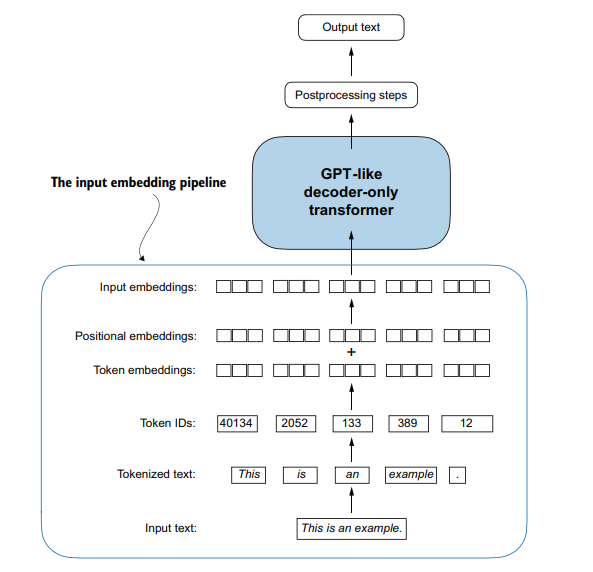


**SUMMARY**

LLMs require textual data to be converted into numerical vectors, known as
embeddings, since they can’t process raw text. Embeddings transform discrete
data (like words or images) into continuous vector spaces, making them compatible with neural network operations.

 As the first step, raw text is broken into tokens, which can be words or characters.
Then, the tokens are converted into integer representations, termed token IDs.

 Special tokens, such as <|unk|> and <|endoftext|>, can be added to enhance
the model’s understanding and handle various contexts, such as unknown
words or marking the boundary between unrelated texts.

 The byte pair encoding (BPE) tokenizer used for LLMs like GPT-2 and GPT-3
can efficiently handle unknown words by breaking them down into subword
units or individual characters.

 We use a sliding window approach on tokenized data to generate input–target
pairs for LLM training.

 Embedding layers in PyTorch function as a lookup operation, retrieving vectors
corresponding to token IDs. The resulting embedding vectors provide continuous representations of tokens, which is crucial for training deep learning models like LLMs.

 While token embeddings provide consistent vector representations for each
token, they lack a sense of the token’s position in a sequence. To rectify this,
two main types of positional embeddings exist: absolute and relative. OpenAI’s
GPT models utilize absolute positional embeddings, which are added to the token
embedding vectors and are optimized during the model training